In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob

files = glob.glob("../datasets/api_data_aadhar_biometric/*.csv")
len(files)

4

In [3]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

In [4]:
print("=== FIRST 5 ROWS OF THE DATASET ===")
display(df.head())

print("\n=== DATASET SHAPE (ROWS, COLUMNS) ===")
print(df.shape)

print("\n=== COLUMN NAMES ===")
print(df.columns.tolist())

print("\n=== DATASET INFORMATION (DTYPES & NON-NULL COUNTS) ===")
df.info()


=== FIRST 5 ROWS OF THE DATASET ===


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,19-09-2025,Goa,North Goa,403502,0,4
1,19-09-2025,Goa,North Goa,403508,1,4
2,19-09-2025,Goa,North Goa,403513,2,0
3,19-09-2025,Goa,North Goa,403527,2,2
4,19-09-2025,Goa,South Goa,403601,7,3



=== DATASET SHAPE (ROWS, COLUMNS) ===
(1861108, 6)

=== COLUMN NAMES ===
['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']

=== DATASET INFORMATION (DTYPES & NON-NULL COUNTS) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


In [11]:
print("=== CONVERTING DATE COLUMN TO DATETIME ===")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print("Date conversion done.")

=== CONVERTING DATE COLUMN TO DATETIME ===
Date conversion done.


In [12]:
print("\n=== CHECKING FOR MISSING VALUES ===")
missing = df.isnull().sum()
print(missing)


=== CHECKING FOR MISSING VALUES ===
date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64


In [14]:
print("\n=== DROPPING ROWS WITH MISSING DATE OR LOCATION ===")
df = df.dropna(subset=['date', 'state', 'district', 'pincode'])

print("Remaining records after drop:", df.shape)


=== DROPPING ROWS WITH MISSING DATE OR LOCATION ===
Remaining records after drop: (1766212, 6)


In [15]:
print("\n=== REMOVING DUPLICATE RECORDS ===")
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print(f"Duplicates removed: {before - after}")


=== REMOVING DUPLICATE RECORDS ===
Duplicates removed: 0


In [16]:
print("Duplicates left:", df.duplicated().sum())
print("Missing values:\n", df.isnull().sum())
print("Date dtype:", df['date'].dtype)

Duplicates left: 0
Missing values:
 date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64
Date dtype: datetime64[ns]


In [18]:
print("=== STANDARDISING COLUMN NAMES ===")

df = df.rename(columns={
    'bio_age_17_': 'bio_age_17_plus'
})

df.columns

=== STANDARDISING COLUMN NAMES ===


Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17',
       'bio_age_17_plus'],
      dtype='object')

In [19]:
print("=== CREATING TOTAL BIOMETRIC ACTIVITY ===")

df['total_biometric_activity'] = (
    df['bio_age_5_17'] + df['bio_age_17_plus']
)

df[['bio_age_5_17', 'bio_age_17_plus', 'total_biometric_activity']].head()

=== CREATING TOTAL BIOMETRIC ACTIVITY ===


,bio_age_5_17,bio_age_17_plus,total_biometric_activity
0,0,4,4
1,1,4,5
2,2,0,2
3,2,2,4
4,7,3,10


In [20]:
print("=== CREATING CHILD-TO-ADULT BIOMETRIC RATIO ===")

df['child_to_adult_ratio'] = (
    df['bio_age_5_17'] / (df['bio_age_17_plus'] + 1)
)

df['child_to_adult_ratio'].describe()

=== CREATING CHILD-TO-ADULT BIOMETRIC RATIO ===


count    1.766212e+06
mean     1.095240e+00
std      1.559346e+00
min      0.000000e+00
25%      3.157895e-01
50%      7.142857e-01
75%      1.333333e+00
max      1.480000e+02
Name: child_to_adult_ratio, dtype: float64

In [21]:
print("=== EXTRACTING TIME FEATURES ===")

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()

df[['date', 'year', 'month', 'month_name']].head()

=== EXTRACTING TIME FEATURES ===


,date,year,month,month_name
0,2025-09-19,2025,9,September
1,2025-09-19,2025,9,September
2,2025-09-19,2025,9,September
3,2025-09-19,2025,9,September
4,2025-09-19,2025,9,September


In [22]:
print("=== MONTHLY AGGREGATION ===")

monthly_df = (
    df.groupby(['year', 'month', 'month_name'], as_index=False)
      .agg({
          'bio_age_5_17': 'sum',
          'bio_age_17_plus': 'sum',
          'total_biometric_activity': 'sum'
      })
)

monthly_df.head()

=== MONTHLY AGGREGATION ===


,year,month,month_name,bio_age_5_17,bio_age_17_plus,total_biometric_activity
0,2025,3,March,3733578,4588644,8322222
1,2025,4,April,4356896,4284783,8641679
2,2025,5,May,3868247,4011709,7879956
3,2025,6,June,3710149,4189140,7899289
4,2025,7,July,4499057,5293495,9792552


In [23]:
print("=== DISTRICT-LEVEL AGGREGATION ===")

district_df = (
    df.groupby(['state', 'district'], as_index=False)
      .agg({
          'bio_age_5_17': 'sum',
          'bio_age_17_plus': 'sum',
          'total_biometric_activity': 'sum',
          'child_to_adult_ratio': 'mean'
      })
)

district_df.head()

=== DISTRICT-LEVEL AGGREGATION ===


,state,district,bio_age_5_17,bio_age_17_plus,total_biometric_activity,child_to_adult_ratio
0,Andaman & Nicobar Islands,Andamans,326,1609,1935,0.296989
1,Andaman & Nicobar Islands,Nicobars,1,1,2,0.500000
2,Andaman & Nicobar Islands,South Andaman,55,269,324,0.206176
3,Andaman and Nicobar Islands,Nicobar,958,797,1755,1.495402
4,Andaman and Nicobar Islands,North And Middle Andaman,3586,2546,6132,2.392735


In [24]:
print("=== FEATURE ENGINEERING SUMMARY ===")
df[['total_biometric_activity', 'child_to_adult_ratio']].describe()

=== FEATURE ENGINEERING SUMMARY ===


,total_biometric_activity,child_to_adult_ratio
count,1.766212e+06,1.766212e+06
mean,3.864828e+01,1.095240e+00
std,1.664470e+02,1.559346e+00
min,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.157895e-01
50%,8.000000e+00,7.142857e-01
75%,2.200000e+01,1.333333e+00
max,1.338100e+04,1.480000e+02


In [25]:
print("=== OVERALL AGE-WISE BIOMETRIC ACTIVITY ===")

age_totals = {
    'Age 5–17': df['bio_age_5_17'].sum(),
    'Age 17+': df['bio_age_17_plus'].sum()
}

age_df = pd.DataFrame(
    list(age_totals.items()),
    columns=['Age Group', 'Total Biometric Activity']
)

age_df

=== OVERALL AGE-WISE BIOMETRIC ACTIVITY ===


,Age Group,Total Biometric Activity
0,Age 5–17,33456647
1,Age 17+,34804412


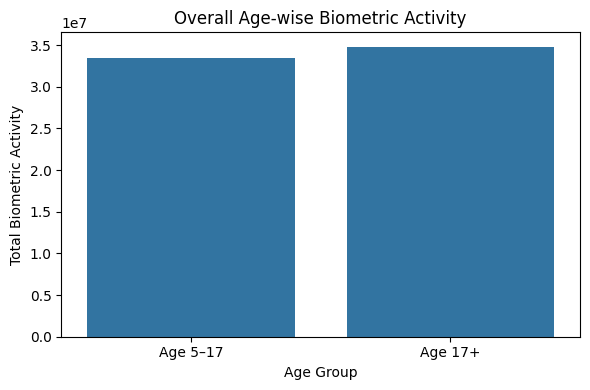

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=age_df,
    x='Age Group',
    y='Total Biometric Activity'
)
plt.title("Overall Age-wise Biometric Activity")
plt.ylabel("Total Biometric Activity")
plt.xlabel("Age Group")
plt.tight_layout()
plt.show()

In [27]:
print("=== SORTING MONTHLY DATA ===")

monthly_df = monthly_df.sort_values(by=['year', 'month'])
monthly_df.head()

=== SORTING MONTHLY DATA ===


,year,month,month_name,bio_age_5_17,bio_age_17_plus,total_biometric_activity
0,2025,3,March,3733578,4588644,8322222
1,2025,4,April,4356896,4284783,8641679
2,2025,5,May,3868247,4011709,7879956
3,2025,6,June,3710149,4189140,7899289
4,2025,7,July,4499057,5293495,9792552


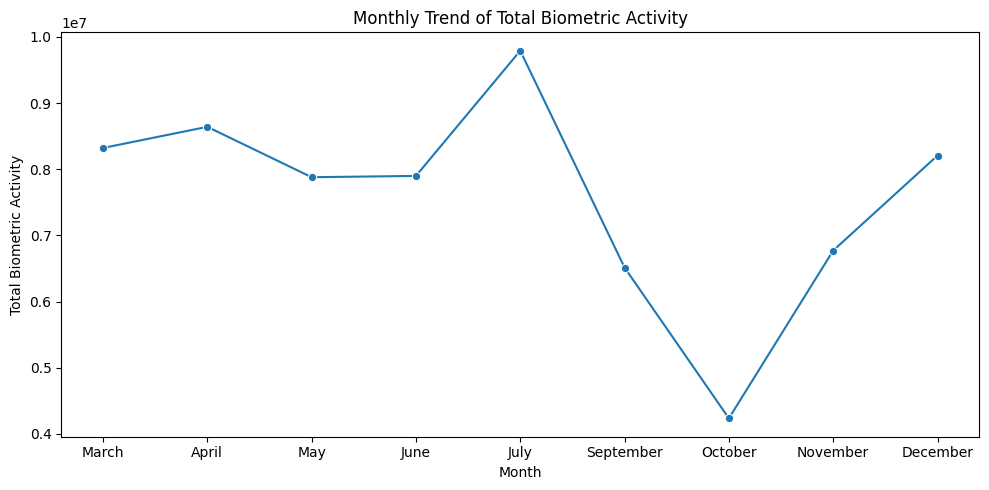

In [28]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=monthly_df,
    x='month_name',
    y='total_biometric_activity',
    marker='o'
)

plt.title("Monthly Trend of Total Biometric Activity")
plt.xlabel("Month")
plt.ylabel("Total Biometric Activity")
plt.tight_layout()
plt.show()

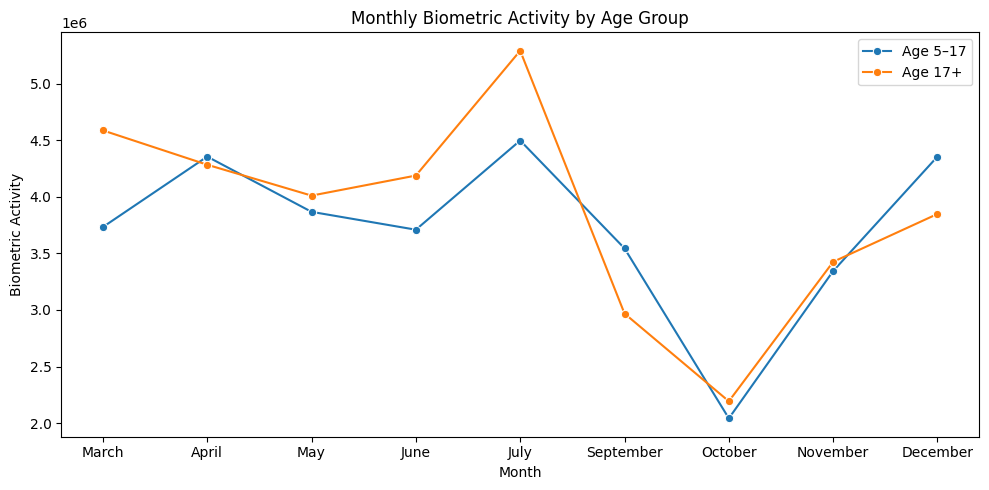

In [29]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=monthly_df,
    x='month_name',
    y='bio_age_5_17',
    marker='o',
    label='Age 5–17'
)

sns.lineplot(
    data=monthly_df,
    x='month_name',
    y='bio_age_17_plus',
    marker='o',
    label='Age 17+'
)

plt.title("Monthly Biometric Activity by Age Group")
plt.xlabel("Month")
plt.ylabel("Biometric Activity")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
print("=== TOP DISTRICTS BY TOTAL BIOMETRIC ACTIVITY ===")

top_districts = (
    district_df
    .sort_values(by='total_biometric_activity', ascending=False)
    .head(10)
)

top_districts

=== TOP DISTRICTS BY TOTAL BIOMETRIC ACTIVITY ===


,state,district,bio_age_5_17,bio_age_17_plus,total_biometric_activity,child_to_adult_ratio
552,Maharashtra,Pune,277443,316149,593592,1.212736
548,Maharashtra,Nashik,208401,353492,561893,0.761077
561,Maharashtra,Thane,198145,361166,559311,0.584763
536,Maharashtra,Jalgaon,145699,262402,408101,0.899530
231,Gujarat,Ahmedabad,163075,236127,399202,0.735601
540,Maharashtra,Mumbai,116741,278332,395073,0.513078
515,Maharashtra,Ahmadnagar,159966,193650,353616,1.944740
763,Rajasthan,Jaipur,155263,194269,349532,1.136586
544,Maharashtra,Nagpur,110440,232553,342993,0.652908
28,Andhra Pradesh,Kurnool,237941,104369,342310,1.546348


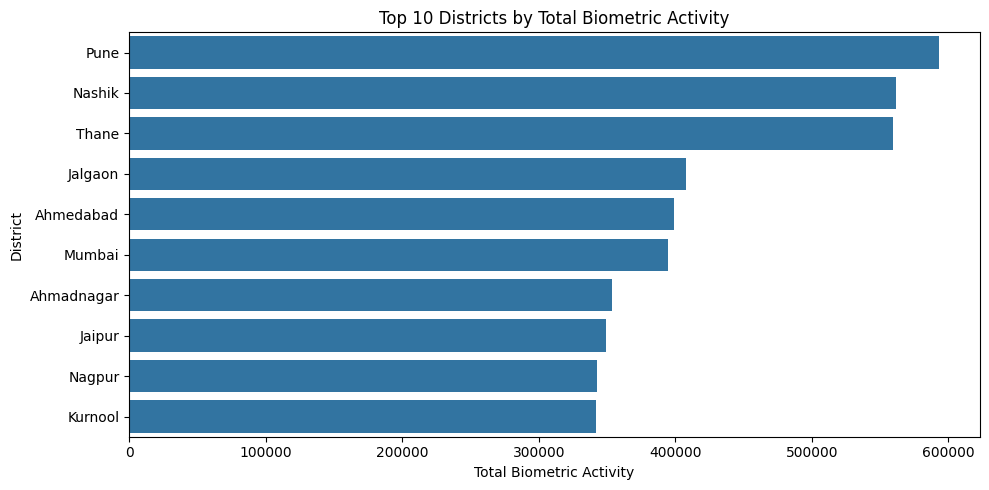

In [31]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=top_districts,
    x='total_biometric_activity',
    y='district'
)

plt.title("Top 10 Districts by Total Biometric Activity")
plt.xlabel("Total Biometric Activity")
plt.ylabel("District")
plt.tight_layout()
plt.show()

In [32]:
print("=== TOP DISTRICTS BY CHILD-TO-ADULT BIOMETRIC RATIO ===")

ratio_districts = (
    district_df
    .sort_values(by='child_to_adult_ratio', ascending=False)
    .head(10)
)

ratio_districts

=== TOP DISTRICTS BY CHILD-TO-ADULT BIOMETRIC RATIO ===


,state,district,bio_age_5_17,bio_age_17_plus,total_biometric_activity,child_to_adult_ratio
341,Jammu and Kashmir,Ramban,21030,7938,28968,5.324854
327,Jammu and Kashmir,Budgam,18002,4547,22549,5.083113
70,Arunachal Pradesh,Tawang,1836,588,2424,4.330770
65,Arunachal Pradesh,Namsai,3401,2403,5804,3.810848
75,Arunachal Pradesh,West Siang,3165,1284,4449,3.549181
883,Tripura,Gomati,11467,2870,14337,3.186747
58,Arunachal Pradesh,Kurung Kumey,1226,2067,3293,3.111610
338,Jammu and Kashmir,Pulwama,19606,12020,31626,3.048288
344,Jammu and Kashmir,Shupiyan,9111,6219,15330,3.019659
975,Uttar Pradesh,Sitapur,196270,62288,258558,2.903959


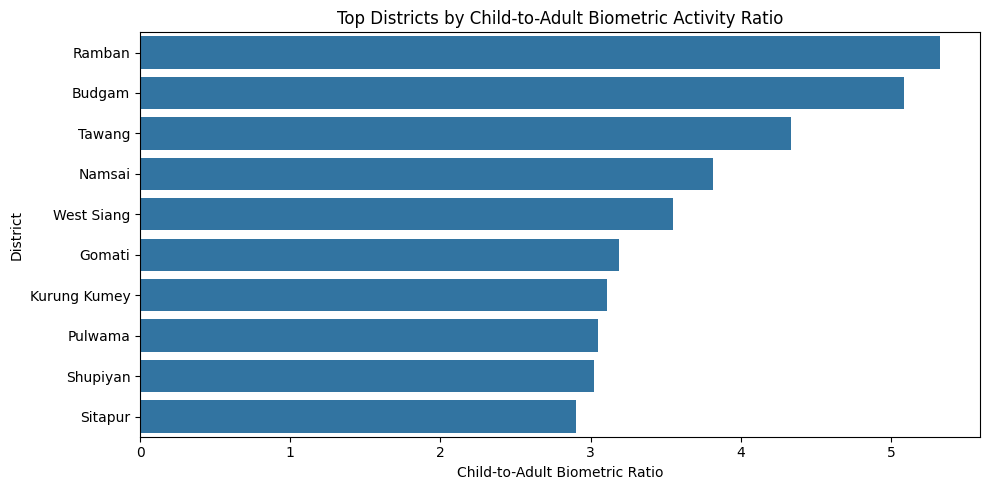

In [33]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=ratio_districts,
    x='child_to_adult_ratio',
    y='district'
)

plt.title("Top Districts by Child-to-Adult Biometric Activity Ratio")
plt.xlabel("Child-to-Adult Biometric Ratio")
plt.ylabel("District")
plt.tight_layout()
plt.show()

In [34]:
print("=== CALCULATING MONTHLY BIOMETRIC VARIABILITY ===")

monthly_df['monthly_change'] = monthly_df['total_biometric_activity'].pct_change() * 100
monthly_df[['month_name', 'total_biometric_activity', 'monthly_change']].head()

=== CALCULATING MONTHLY BIOMETRIC VARIABILITY ===


,month_name,total_biometric_activity,monthly_change
0,March,8322222,NaN
1,April,8641679,3.838602
2,May,7879956,-8.814526
3,June,7899289,0.245344
4,July,9792552,23.967512


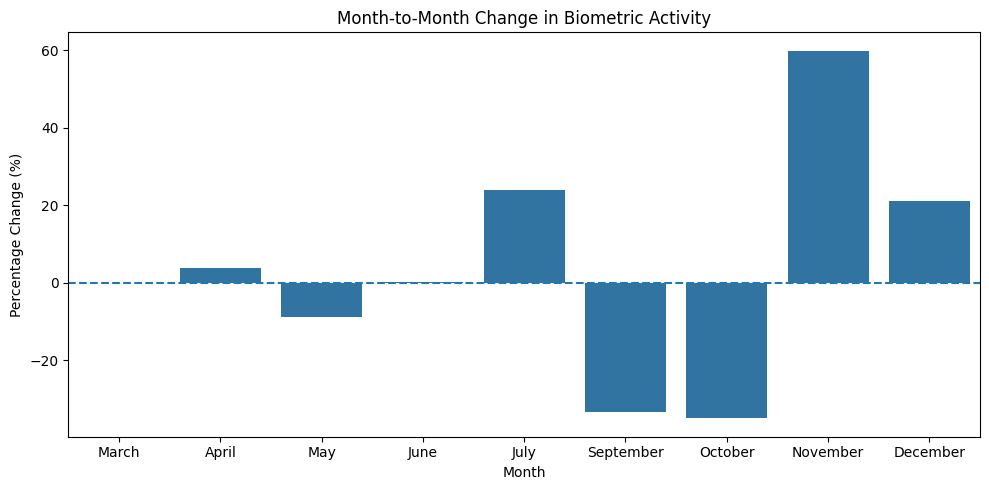

In [35]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=monthly_df,
    x='month_name',
    y='monthly_change'
)

plt.axhline(0, linestyle='--')
plt.title("Month-to-Month Change in Biometric Activity")
plt.xlabel("Month")
plt.ylabel("Percentage Change (%)")
plt.tight_layout()
plt.show()


In [36]:
total_records = df.shape[0]
print("Total Records Analysed:", total_records)


Total Records Analysed: 1766212


In [38]:
num_states = df['state'].nunique()
print("States / UTs:", num_states)

num_districts = df['district'].nunique()
print("Districts:", num_districts)

num_pincodes = df['pincode'].nunique()
print("Pincodes:", num_pincodes)

States / UTs: 57
Districts: 974
Pincodes: 19707
